# Cross-Validation Analysis with Ratio Probing


This cell performs a cross-validation analysis for decoding P300 features. For each subject, it tests a range of class balancing ratios (using `balance_classes`) during training. Ratio 12 means nontarget epochs outnumber target epochs by factor 12. To probe the original ratio of ~1:13, simply comment out `balance_classes`.

- Note: This takes about 15 min to run for 12 ratios; much variability between runs due to random sampling of balanced epochs

The code:
- Loads the data for each subject.
- Sets up a 4-fold cross-validation.
- For each ratio (from 1 to 13 in steps of 1), it:
  - Trains an LDA classifier after filtering and balancing the training epochs.
  - Evaluates the model on the test data, computing both precision-recall AUC and a correlation-based decision metric.
  - Records the subject-level accuracy (computed from the number of correctly classified trials over available trials).
- It stores per-ratio accuracies in the dictionary `ratio_accuracy_subjects` and overall decoding metrics in `results_decoding`.


In [1]:
import os
from os.path import join
import numpy as np
from scipy.stats import pearsonr
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.covariance import LedoitWolf
from sklearn.metrics import precision_recall_curve, auc
import warnings
warnings.filterwarnings("ignore")

wd = r'C:\Users\Radovan\OneDrive\Radboud\Studentships\Jordy Thielen\root'
os.chdir(wd)
data_dir = join(wd, "data")
experiment_dir = join(data_dir, "experiment")
files_dir = join(experiment_dir, 'files')
sourcedata_dir = join(experiment_dir, 'sourcedata')
derivatives_dir = join(join(experiment_dir, 'derivatives'))

analysis_dir = join(data_dir, "analysis")
p300_dir = join(analysis_dir, "p300")
decoding_results_dir = join(p300_dir, "decoding_results") 
plots_dir = join(p300_dir, "plots", "decoding")
features_dir = join(p300_dir, "plots", "features")

subjects = ["VPpdia","VPpdib", "VPpdic", "VPpdid", "VPpdie", "VPpdif", "VPpdig","VPpdih", "VPpdii", "VPpdij",
            "VPpdik", "VPpdil", "VPpdim", "VPpdin", "VPpdio", "VPpdip", "VPpdiq", "VPpdir", "VPpdis", "VPpdit",
            "VPpdiu", "VPpdiv", "VPpdiw", "VPpdix","VPpdiy", "VPpdiz", "VPpdiza", "VPpdizb", "VPpdizc"]


In [2]:
def balance_classes(X, y, ratio_0_to_1=1.0):
    
    """
    Sub-select X and y based on a specified ratio of 0s to 1s, keeping the original order.

    Parameters:
    X (numpy.ndarray): Feature matrix of shape (n_samples, n_features).
    y (numpy.ndarray): Label vector of shape (n_samples,).
    ratio_0_to_1 (float): The desired ratio of 0s to 1s in the balanced dataset.

    Returns:
    X_balanced, y_balanced: Sub-selected feature matrix and label vector.
    """
    # Step 1: Identify indices of 0s and 1s
    indices_0 = np.where(y == 0)[0]
    indices_1 = np.where(y == 1)[0]
    
    # Step 2: Calculate the number of samples to select for each class
    num_1s = len(indices_1)
    num_0s = min(len(indices_0), int(num_1s * ratio_0_to_1))
    
    # Step 3: Randomly sample the desired number of 0s and 1s
    selected_indices_0 = np.random.choice(indices_0, num_0s, replace=False)
    selected_indices_1 = np.random.choice(indices_1, num_1s, replace=False)
    
    # Step 4: Combine selected indices and sort to preserve original order
    balanced_indices = np.sort(np.concatenate([selected_indices_0, selected_indices_1]))
    
    # Step 5: Sub-select X and y based on the balanced indices
    X_balanced = X[balanced_indices]
    y_balanced = y[balanced_indices]
    
    return X_balanced, y_balanced

In [3]:
def filter_valid_epochs(X, y, z=None, return_mask=False):
    """
    Filters out epochs where either the features in X or the labels in y contain NaN values.
    Optionally, if a z array is provided, it is filtered similarly.
    
    Parameters:
        X (np.ndarray): A 2D numpy array with shape (n_epochs, n_features).
        y (np.ndarray): A 1D numpy array with shape (n_epochs,).
        z (np.ndarray, optional): An array that will be filtered using the same mask.
        return_mask (bool, optional): If True, the boolean mask used for filtering is returned.
    
    Returns:
        filtered_X (np.ndarray): X with only rows that have no NaN values.
        filtered_y (np.ndarray): y with only entries corresponding to valid epochs.
        filtered_z (np.ndarray or None): Filtered z array (if provided) or None.
        mask (np.ndarray, optional): The boolean mask of valid epochs; only returned if return_mask=True.
    """
    # Create a mask for valid labels and features
    valid_label_mask = ~np.isnan(y)
    valid_feature_mask = ~np.isnan(X).any(axis=1)
    combined_mask = valid_label_mask & valid_feature_mask

    # Apply the mask to X and y
    filtered_X = X[combined_mask]
    filtered_y = y[combined_mask]
    
    if z is not None:
        filtered_z = z[combined_mask]
    else:
        filtered_z = None

    if return_mask:
        return filtered_X, filtered_y, filtered_z, combined_mask
    else:
        return filtered_X, filtered_y, filtered_z

In [ ]:
# --- Parameters ---
discard_threshold = 10
task = 'covert'
# List of balance_ratios to test in balance_classes:
balance_ratios = np.arange(1, 13, 1)

# Dictionary to store subject-level accuracies per ratio.
ratio_accuracy_subjects = {ratio: [] for ratio in balance_ratios}
discarded_trials = []  # Optional: to record the fraction of discarded trials

# Loop over subjects
for subject in subjects:
    file_dir = os.path.join(derivatives_dir, 'features', "p300", f"sub-{subject}")
    file_path = os.path.join(file_dir, f"sub-{subject}_task-{task}_p300_features_wo_baselinecorrect.npz")
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue

    # Load the data from the NPZ file
    npz_data = np.load(file_path)
    # Extract data
    X = npz_data['X']  # EEG data: trials x epochs x channels x features
    y = npz_data['y']  # Labels indicating cued side: trials
    z = npz_data['z']  # Left and right targets: trials x epochs x sides

    # Cross-validation setup
    n_folds = 4
    n_trials = int(X.shape[0] / n_folds)
    folds = np.repeat(np.arange(n_folds), n_trials)
    
    # For each balancing ratio, run cross validation and record subject-level accuracy.
    for ratio in balance_ratios:
        fold_correct_trials = []  # List to store the number of correct trials per fold
        discarded_trial_counter = 0

        # Cross-validation loop
        for i_fold in range(n_folds):
            # Split into train and test sets
            X_trn_trials = X[folds != i_fold]
            y_trn_trials = y[folds != i_fold]
            z_trn_trials = z[folds != i_fold]

            X_tst_trials = X[folds == i_fold]
            y_tst_trials = y[folds == i_fold]
            z_tst_trials = z[folds == i_fold]

            ### TRAINING
            # Flatten training trials into epochs.
            # (Flatten both the trial and epoch dimensions.)
            X_trn_epochs = X_trn_trials.reshape(-1, X_trn_trials.shape[2] * X_trn_trials.shape[3])
            # Extract labels for training epochs using z and y 
            trial_indices_trn = np.arange(len(y_trn_trials))
            y_trn_epochs = z_trn_trials[trial_indices_trn, :, y_trn_trials].reshape(-1)

            # Filter training epochs.
            X_trn_epochs, y_trn_epochs, _ = filter_valid_epochs(X_trn_epochs, y_trn_epochs)
            # Balance training classes with the current ratio.
            X_trn_epochs, y_trn_epochs = balance_classes(X_trn_epochs, y_trn_epochs, ratio_0_to_1=ratio)

            ### TESTING
            # Flatten testing trials into epochs.
            X_tst_epochs = X_tst_trials.reshape(-1, X_tst_trials.shape[2] * X_tst_trials.shape[3])
            # Extract labels for testing epochs using z and y for indexing.
            trial_indices_tst = np.arange(len(y_tst_trials))
            y_tst_epochs = z_tst_trials[trial_indices_tst, :, y_tst_trials].reshape(-1)
            # Reshape z_tst_trials into epochs.
            z_tst_epochs = z_tst_trials.reshape(len(y_tst_trials) * z_tst_trials.shape[1], 2)
            
            # Filter testing epochs and also retrieve the original mask.
            X_tst_epochs, y_tst_epochs, z_tst_epochs, combined_mask_tst = filter_valid_epochs(
                X_tst_epochs, y_tst_epochs, z=z_tst_epochs, return_mask=True
            )
            
            # Sanity check for training data.
            if np.isnan(X_trn_epochs).any() or np.isnan(y_trn_epochs).any():
                raise ValueError("NaNs found in training epochs after filtering!")
            
            # Calculate the number of preserved epochs per trial for testing.
            epoch_counts = combined_mask_tst.reshape(len(y_tst_trials), -1)
            num_epochs = np.sum(epoch_counts, axis=1)
            
            # Rebuild trial structure for testing data based on num_epochs.
            nested_X_tst_trials = []
            nested_z_tst_epochs = []
            start_idx = 0
            for trial_idx, n_ep in enumerate(num_epochs):
                end_idx = start_idx + n_ep
                nested_X_tst_trials.append(X_tst_epochs[start_idx:end_idx])
                nested_z_tst_epochs.append(z_tst_epochs[start_idx:end_idx])
                start_idx = end_idx

            ### Fit LDA model
            lda = LDA(solver="lsqr", covariance_estimator=LedoitWolf())
            lda.fit(X_trn_epochs, y_trn_epochs)

            # Evaluate model on test data for the current fold.
            correct_trials = 0
            for t_idx in range(len(y_tst_trials)):
                num_preserved_epochs = num_epochs[t_idx]
                if num_preserved_epochs < discard_threshold:
                    discarded_trial_counter += 1
                    continue

                # Extract left and right targets and remove NaNs.
                left_targets = nested_z_tst_epochs[t_idx][:, 0]
                left_targets = left_targets[~np.isnan(left_targets)]
                right_targets = nested_z_tst_epochs[t_idx][:, 1]
                right_targets = right_targets[~np.isnan(right_targets)]
                
                # Get the cued side and corresponding targets.
                cued_side = y_tst_trials[t_idx]
                cued_targets = nested_z_tst_epochs[t_idx][:, cued_side]
                
                # Compute LDA decision function scores for the trial's epochs.
                epoch_scores = lda.decision_function(nested_X_tst_trials[t_idx])
                
                # Compute correlation-based decision.
                corr_left, _ = pearsonr(epoch_scores, left_targets)
                corr_right, _ = pearsonr(epoch_scores, right_targets)
                decision = 0 if corr_left > corr_right else 1
                if decision == cued_side:
                    correct_trials += 1
            
            fold_correct_trials.append(correct_trials)
        
        # Compute the subject's accuracy for the current ratio.
        subject_accuracy = np.mean(fold_correct_trials) / (y.size/ n_folds)

        # Save the subject's accuracy for the current ratio.
        ratio_accuracy_subjects[ratio].append(subject_accuracy)
    
    # Optionally record the fraction of discarded trials.
    discarded_trials.append([subject, discarded_trial_counter / n_folds])

# --- Compute the Grand Average per Ratio Across Subjects ---
overall_results = []  # List to store tuples: (ratio, mean_accuracy, se_accuracy)
for ratio in sorted(ratio_accuracy_subjects.keys()):
    subject_accuracies = ratio_accuracy_subjects[ratio]
    overall_mean = np.mean(subject_accuracies)
    overall_se = np.std(subject_accuracies, ddof=1) / np.sqrt(len(subject_accuracies))
    overall_results.append((ratio, overall_mean, overall_se))

# --- Convert the Overall Results to a Structured Array for Saving ---
dtype = [('ratio', 'f8'), ('mean_accuracy', 'f8'), ('se_accuracy', 'f8')]
group_results = np.array(overall_results, dtype=dtype)

# Save the aggregated results to a file.
np.save(os.path.join(decoding_results_dir, f"{task}_grand_average_accuracy_per_ratio.npy"), group_results)


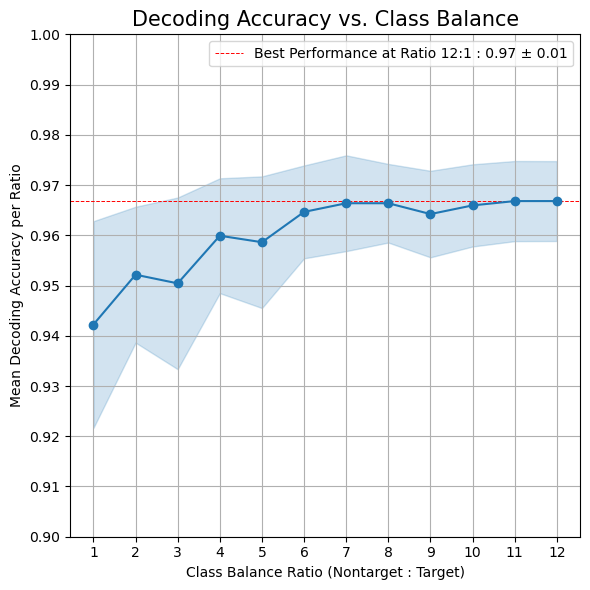

In [ ]:
import matplotlib.pyplot as plt
# --- Compute Overall (Across Subjects) Accuracy for Each Ratio ---
overall_accuracy = {}
for ratio in balance_ratios:
    subject_accuracies = ratio_accuracy_subjects[ratio]
    overall_mean = np.mean(subject_accuracies)
    overall_se = np.std(subject_accuracies, ddof=1) / np.sqrt(len(subject_accuracies))
    overall_accuracy[ratio] = (overall_mean, overall_se)

# --- Plot Accuracy vs Ratio ---
ratios_sorted = sorted(overall_accuracy.keys())
mean_accuracies = [overall_accuracy[r][0] for r in ratios_sorted]
se_accuracies = [overall_accuracy[r][1] for r in ratios_sorted]

plt.figure(figsize=(6, 6))

max_perf = np.max(mean_accuracies)
max_perf_se = se_accuracies[np.argmax(mean_accuracies)]
best_ratio = np.argmax(mean_accuracies) + 1
# Plot the mean accuracy line with markers
plt.axhline(y=max_perf, color='red', linestyle='--', linewidth=0.7, label = f'Best Performance at Ratio {best_ratio}:1 : {max_perf:.2f} ± {max_perf_se:.2f}')
plt.plot(ratios_sorted, mean_accuracies, 'o-', color='tab:blue', label='')
# Fill between (mean - se) and (mean + se)
plt.fill_between(ratios_sorted, 
                 np.array(mean_accuracies) - np.array(se_accuracies), 
                 np.array(mean_accuracies) + np.array(se_accuracies), 
                 color='tab:blue', alpha=0.2)

plt.xlabel('Class Balance Ratio (Nontarget : Target)')
plt.ylabel('Mean Decoding Accuracy per Ratio')
plt.ylim([0.4,1])
plt.xticks(balance_ratios)
plt.yticks(np.linspace(0.4,1,11))
plt.title('Decoding Accuracy vs. Class Balance', fontsize = 15)
plt.grid(True)
plt.legend(loc= 'upper right')
plt.tight_layout()

plt.savefig(join(plots_dir, f"{task}_lda_p300_decoding_per_ratio_results.png"), dpi=300)
plt.savefig(join(plots_dir, f"{task}_lda_p300_decoding_per_ratio_results.svg"), dpi=300)

plt.show()